In [10]:
# 引入必需的库

import numpy as np
import matplotlib.pyplot as plt

# sklearn 用于数据挖掘、数据分析和机器学习，内置很多人工智能函数
import sklearn
import sklearn.datasets
import sklearn.linear_model

# 工具函数
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets
# 单元测试工具函数
from testCases import *

%matplotlib inline

# 设置固定的随机数种子便于测试
np.random.seed(1)

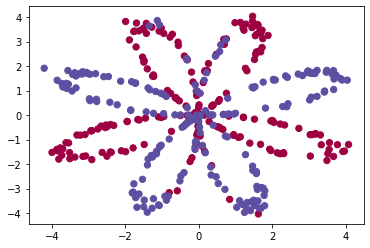

In [11]:
# 使用工具类加载训练数据
# 该工具方法将加载 400 个有颜色的点
# X 的维度为 (2, 400)，X[0] 为横坐标，X[1] 为纵坐标
# Y 的维度为 (1, 400)，每项取值 0 或 1，分别代表红色和蓝色

X, Y = load_planar_dataset()

# 使用 scatter 绘制上述点
# 参数：横坐标、纵坐标、颜色
# plt.cm.Spectral 调色板中，0 代表红，1 代表蓝
plt.scatter(X[0, :], X[1, :],c=Y.ravel(), s=40, cmap=plt.cm.Spectral)

In [12]:
# X、Y 的维度
shape_X = X.shape
shape_Y = Y.shape

# 样本数量
m = Y.shape[1]

# 打印
print(f'X 的维度是 {shape_X}')
print(f'Y 的维度是 {shape_Y}')
print(f'样本数量是 {m}')

X 的维度是 (2, 400)
Y 的维度是 (1, 400)
样本数量是 400


In [13]:
# 使用 sklearn 的单神经元网络

# 生成 LogisticRegressionCV 对象，内部实现了单神经元网络
clf = sklearn.linear_model.LogisticRegressionCV()

# 传入训练数据进行训练
# 学习率、训练次数等均有默认值，所以只传入训练数据即可
clf.fit(X.T, Y.T.ravel())

LogisticRegressionCV()

预测准确度是: 47 % 
clf score: 0.470000


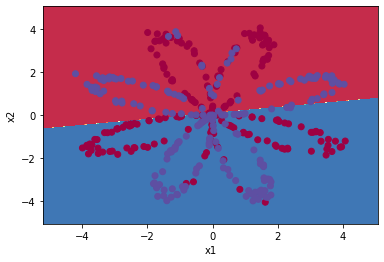

In [14]:
# 对训练数据进行预测
# LR_predictions 是一个 size 为 400 的 结果数组
LR_predictions = clf.predict(X.T)

# 使用算法计算准确度
print('预测准确度是: %d ' % float((np.dot(Y, LR_predictions) + np.dot(1 - Y,1 - LR_predictions)) / float(Y.size) * 100) + '% ')

# 使用 clf 自带算法求准确度
print('clf score: %f' % clf.score(X.T,Y.T.ravel()))

# 使用工具函数画出预测图
# 工具函数会使用上述模型预测整个图的点
# 再将训练数据画出，从而比较精确度
plot_decision_boundary(lambda x: clf.predict(x), X, Y.ravel())

开始编写多神经元的浅层神经网络

![](https://vscode-remote%2Bwsl-002bubuntu-002d20-002e04.vscode-resource.vscode-cdn.net/home/linux/learning/2%E6%B5%85%E5%B1%82%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C/images/download.png)

In [15]:
# 初始化参数 w 和 b
# n_x 输入层的神经元个数
# n_h 隐藏层的神经元个数
# n_y 输出层的神经元个数

def initialize_parameters(n_x, n_h, n_y):
    # 指定随机数种子
    np.random.seed(2)

    # 初始化第一层(隐藏层)的参数 w
    # W1 的维度为 (n_h, n_x)，即 (隐藏层神经元个数, 输入层神经元个数[特征个数])
    W1 = np.random.randn(n_h, n_x) * 0.01

    # 由于 w 已经随机，b 可以为 0
    # 每个神经元只有一个对应的 b
    # 所以 b1 的维度为 (n_h, 1)，即 (隐藏层神经元个数, 1)
    b1 = np.zeros(shape=(n_h, 1))

    # 初始化第二层(输出层)的 w 和 b
    # W2 的维度为 (n_y, n_h)，即 (输出层的神经元个数, 隐藏层的神经元个数)
    W2 = np.random.randn(n_y, n_h) * 0.01
    # b1 的维度为 (n_y, 1)，即 (输出层的神经元个数, 1)
    b2 = np.zeros(shape=(n_y, 1))

    # 返回参数
    return {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2
    }


tach 函数

![](./images/tanh.png)

In [16]:
# 前向传播
# X 是输入的特征，维度 (横纵坐标， 样本数)

def forward_propagation(X, parameters):
    # 获取样本数
    m = X.shape[1]

    # 从字典中取出参数
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    # 第一层的前向传播
    # 使用 tanh 激活函数
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)

    # 第二层的前向传播
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    cache = {
        "Z1": Z1,
        "A1": A1,
        "Z2": Z2,
        "A2": A2
    }
    
    return A2, cache
    

成本函数

![](./images/cost.png)

In [17]:
# 计算成本
# A2 是神经网络最后一层的输出结果
# Y 是数据颜色标签

def compute_cost(A2, Y, parameters):
    m = Y.shape[1]
    
    logprobs = np.multiply(np.log(A2), Y) + np.multiply((1-Y), np.log(1-A2))
    return -np.sum(logprobs)/m


计算梯度

![](./images/gradient.png)

In [18]:
# 反向传播

def backward_propagation(parameters, cache, X, Y):
    # 样本数
    m = X.shape[1]

    # 取出 w, b
    W1 = parameters['W1']
    W2 = parameters['W2']

    # 取出 A1, A2
    A1 = cache['A1']
    A2 = cache['A2']

    # 计算梯度
    dZ2 = A2 - Y
    dW2 = (np.dot(dZ2, A1.T)) / m
    db2 = (np.sum(dZ2, axis=1, keepdims=True)) / m
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = (np.dot(dZ1, X.T)) / m
    db1 = (np.sum(dZ1, axis=1, keepdims=True)) / m

    return {
        'dW1': dW1,
        'db1': db1,
        'dW2': dW2,
        'db2': db2
    }

In [19]:
# 梯度下降
# parameters: w, b
# grads: 梯度

def update_parameters(parameters, grads, learning_rate=1.2):
    # 取出参数
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']

    # 更新参数
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2

    return {
        'W1': W1,
        'b1': b1,
        'W2': W2,
        'b2': b2
    }


In [20]:
# 训练模型
# X 输入特征
# Y 标签
# n_h 隐藏层神经元个数
# num_iterations 训练次数

def nn_model(X, Y, n_h, num_iterations=10000, print_cost=False):
    # 设置随机数种子
    np.random.seed(3)

    # 输入特征个数/维度即输入层的神经元个数
    # 在本例中是 400
    n_x = X.shape[0]
    # 标签维度即输出层的神经元个数
    # 在本例中标签为 0/1，即输出层神经元个数为 1
    n_y = Y.shape[0]

    # 初始化 W1、b1、W2、b2
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    # 开始训练
    for i in range(num_iterations):
        # 前向传播
        A2, cache = forward_propagation(X, parameters)

        # 计算成本
        cost = compute_cost(A2, Y, parameters)

        # 反向传播
        grads = backward_propagation(parameters, cache, X, Y)

        # 进行一次优化
        parameters = update_parameters(parameters, grads)

        # 每 1000 次打印一次成本
        if print_cost and i % 1000 == 0:
            print(f'训练 {i} 次后，成本是: {cost}')

    # 返回训练好的参数
    return parameters


In [21]:
# 预测函数
# parameters 训练好的参数
# X 预测数据

def predict(parameters, X):
    # 执行一次前向传播
    A2, cache = forward_propagation(X, parameters)
    # 四舍五入
    # 大于 0.5 就是 1，否则就是 0
    return np.round(A2)


训练 0 次后，成本是: 0.6930480201239823
训练 1000 次后，成本是: 0.2880832935690184
训练 2000 次后，成本是: 0.25438549407324546
训练 3000 次后，成本是: 0.23386415038952207
训练 4000 次后，成本是: 0.2267924874485401
训练 5000 次后，成本是: 0.2226442754929902
训练 6000 次后，成本是: 0.21973140404281322
训练 7000 次后，成本是: 0.21750365405131297
训练 8000 次后，成本是: 0.21958831178969546
训练 9000 次后，成本是: 0.2186435598432369
预测准确率是: 90%


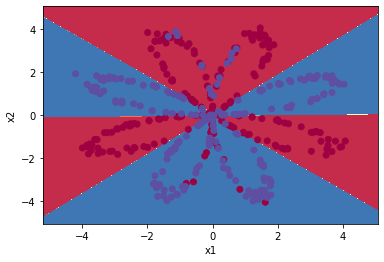

In [22]:
# 开始测试训练完成的浅层神经网络

# 使用训练数据训练模型，得到参数
parameters = nn_model(X, Y, n_h=4, num_iterations=10000, print_cost=True)

# 使用参数预测数据
predictions = predict(parameters, X)
# 计算准确率
print('预测准确率是: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

# 绘制预测结果
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y.ravel())


1个隐藏层神经元时的准确度是: 67.5 %
2个隐藏层神经元时的准确度是: 67.25 %
3个隐藏层神经元时的准确度是: 90.75 %
4个隐藏层神经元时的准确度是: 90.5 %
5个隐藏层神经元时的准确度是: 91.25 %
20个隐藏层神经元时的准确度是: 90.0 %
50个隐藏层神经元时的准确度是: 90.75 %


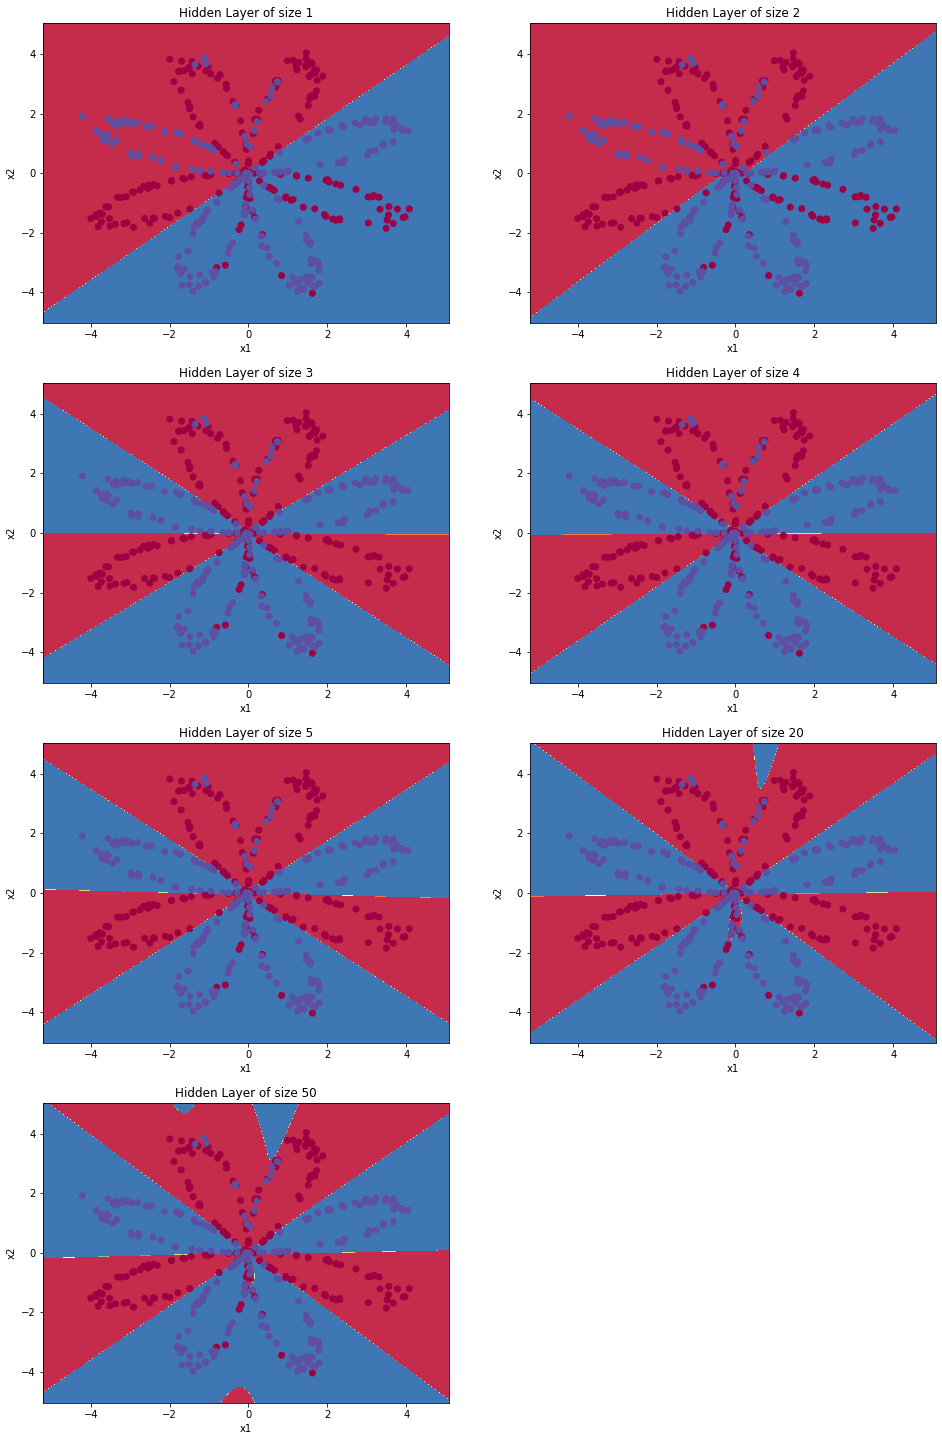

In [23]:
# 对比不同神经元个数的不同准确度

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]  # 不同的神经元个数
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i + 1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations=5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y.ravel())
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y, predictions.T) + np.dot(1 - Y,
                     1 - predictions.T)) / float(Y.size) * 100)
    print("{}个隐藏层神经元时的准确度是: {} %".format(n_h, accuracy))
